## TASK

@danielemoro the repo you're after is https://bitbucket.org/bsu-slim/valence-affect/ . If you clone that then run jupyter notebook from the code folder, you'll see a lot of notebooks. Start with valence-sentiment.ipynb. That points to a pickle that has the descriptions and the affect labels (nicely formatted with a column label for each row!). You know the rest: map from the descriptions to a distribution over the 16 labels. I'd start with BERT embeddings to represent the descriptions. Maybe use the flair or stanfordnlp libraries. Should be pretty easy to get setup and then you can optimize. I'd just do some kind of cross validation using 10 folds or something. (edited) 

## Import libs

In [228]:
import pandas as pd
import pickle
from tqdm import tqdm_notebook as tqdm
from textblob import TextBlob
import torch
from flair.embeddings import BertEmbeddings
from flair.data import Sentence
import numpy as np
from collections import Counter
import seaborn as sn
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import textblob
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from keras.models import load_model
from sklearn.metrics import precision_recall_fscore_support
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))

BERT = BertEmbeddings()

## Check that BERT embeddings make sense

In [3]:
cos = torch.nn.CosineSimilarity(dim=0, eps=1e-6)

def _bertembed(sent, index):
    sentence = Sentence(sent)
    BERT.embed(sentence)
    return sentence[index].embedding

bank1 = _bertembed("the bank next to the river", 1)
bank2 = _bertembed("we robbed the big bank", 4)
print(cos(bank1, bank2))

print(cos(_bertembed("bank", 0), _bertembed("bank", 0)))

print(cos(_bertembed("sandy bank", 1), _bertembed("rich bank", 1)))

print(cos(_bertembed("wealthy bank", 1), _bertembed("rich bank", 1)))

print(cos(_bertembed("sandy bank", 1), _bertembed("rocky bank", 1)))

tensor(0.4644, device='cuda:0')
tensor(1., device='cuda:0')
tensor(0.8639, device='cuda:0')
tensor(0.8962, device='cuda:0')
tensor(0.9534, device='cuda:0')


## Read data

In [4]:
data = pd.read_pickle('../data/sentiment_data.pickle')

# source https://github.com/susanli2016/NLP-with-Python/blob/master/Multi-Class%20Text%20Classification%20LSTM%20Consumer%20complaints.ipynb

REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
#     text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text

data['desc'] = data['description'].apply(clean_text)

In [5]:
data.describe()

video_title    interest       alarm   confusion  understanding  \
count   940.000000  940.000000  940.000000  940.000000     940.000000   
mean    484.898936    0.221277    0.103191    0.151064       0.120213   
std     264.022306    0.415327    0.304371    0.358302       0.325383   
min      21.000000    0.000000    0.000000    0.000000       0.000000   
25%     256.750000    0.000000    0.000000    0.000000       0.000000   
50%     492.500000    0.000000    0.000000    0.000000       0.000000   
75%     710.250000    0.000000    0.000000    0.000000       0.000000   
max     941.000000    1.000000    1.000000    1.000000       1.000000   

       frustration      relief      sorrow         joy       anger  \
count   940.000000  940.000000  940.000000  940.000000  940.000000   
mean      0.110638    0.079787    0.147872    0.144681    0.101064   
std       0.313851    0.271108    0.355162    0.351966    0.301574   
min       0.000000    0.000000    0.000000    0.000000    0.000000   
25%       0.000000    0.000000    0.000000    0.000000    0.000000   
50%       0.000000    0.000000    0.000000    0.000000    0.000000   
75%       0.000000    0.000000    0.000000    0.000000    0.000000   
max       1.000000    1.000000    1.000000    1.000000    1.000000   

        gratitude        fear        hope     boredom    surprise     disgust  \
count  940.000000  940.000000  940.000000  940.000000  940.000000  940.000000   
mean     0.084043    0.121277    0.086170    0.086170    0.131915    0.056383   
std      0.277599    0.326622    0.280765    0.280765    0.338578    0.230783   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

           desire  
count  940.000000  
mean     0.067021  
std      0.250192  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      0.000000  
max      1.000000

In [6]:
word_counter = Counter()
for p in data.desc:
    word_counter.update(p.split())

print("Vocabulary size: ", len(word_counter.keys()))

Vocabulary size:  877


Average phrase length:  7.9361702127659575


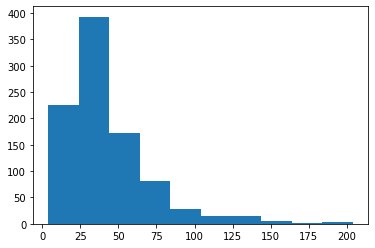

In [7]:
plt.hist(data.desc.apply(len))
print("Average phrase length: ", data.desc.apply(lambda x: len(x.split())).mean())

In [8]:
print("Most common words")
Counter([item for sublist in [d.split() for d in data['desc'].values] for item in sublist]).most_common(20)

Most common words


[('the', 575),
 ('robot', 527),
 ('and', 479),
 ('its', 250),
 ('is', 211),
 ('to', 153),
 ('up', 153),
 ('arms', 148),
 ('down', 145),
 ('head', 143),
 ('looks', 141),
 ('a', 133),
 ('then', 124),
 ('eyes', 110),
 ('he', 102),
 ('it', 92),
 ('in', 90),
 ('moves', 89),
 ('moved', 72),
 ('back', 64)]

## Get valence pairs

In [9]:
(data.understanding.values + data.confusion.values).max()

2

#### The above value doesn't make sense! understanding and confusion should be mutually exclusive. Therefore, we cannot make valence pairs.

## Apply BERT embedding

In [10]:
MAX_WORDS = 80
pad = lambda x: np.pad(x, [[0,MAX_WORDS - len(x[:MAX_WORDS])], [0,0]], 'constant')
mask = np.random.rand(3072) > 0

def get_embedding(sent):
    if(len(sent.strip()) == 0):
        return np.zeros((MAX_WORDS, 3072))
    sentence = Sentence(sent)
    BERT.embed(sentence)
    embed = pad(np.array([w.embedding.cpu().numpy()[mask] for w in sentence]))
    return embed

In [11]:
data['desc_bert'] = data['desc'].apply(get_embedding)

In [12]:
X = np.stack(data.desc_bert.values, axis=0)

# If we want to concat the word vectors:
# X = X.reshape(X.shape[:-2] + (-1,))

# If we want to sum the word vectors:
X = np.sum(X, axis=1)

Y = data.loc[:, 'interest':'desire'].values

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
X.shape, Y.shape, X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((940, 3072), (940, 16), (846, 3072), (94, 3072), (846, 16), (94, 16))

## Model

In [13]:
model = Sequential()
model.add(Dense(128, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 800
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, verbose=1, batch_size=846)
model.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 846 samples, validate on 94 samples
Epoch 1/800





846/846 [==============================] - 1s 603us/step - loss: 0.8546 - acc: 0.4256 - val_loss: 0.5165 - val_acc: 0.7906
Epoch 2/800
846/846 [==============================] - 0s 24us/step - loss: 0.5216 - acc: 0.7885 - val_loss: 0.4244 - val_acc: 0.8757
Epoch 3/800
846/846 [==============================] - 0s 25us/step - loss: 0.4238 - acc: 0.8735 - val_loss: 0.3955 - val_acc: 0.8843
Epoch 4/800
846/846 [==============================] - 0s 25us/step - loss: 0.3923 - acc: 0.8874 - val_loss: 0.3852 - val_acc: 0.8836
Epoch 5/800
846/846 [==============================] - 0s 25us/step - loss: 0.3812 - acc: 0.8870 - val_loss: 0.3793 - val_acc: 0.8836
Epoch 6/800
846/846 [==============================] - 0s 24us/step - loss: 0.3742 - acc: 0.8870 - val_loss: 0.3749 - val_acc: 0.8836
Epoch 7/800
846/846 [======================

Epoch 101/800
846/846 [==============================] - 0s 24us/step - loss: 0.2652 - acc: 0.8945 - val_loss: 0.3090 - val_acc: 0.8923
Epoch 102/800
846/846 [==============================] - 0s 22us/step - loss: 0.2645 - acc: 0.8944 - val_loss: 0.3088 - val_acc: 0.8930
Epoch 103/800
846/846 [==============================] - 0s 22us/step - loss: 0.2638 - acc: 0.8945 - val_loss: 0.3087 - val_acc: 0.8930
Epoch 104/800
846/846 [==============================] - 0s 24us/step - loss: 0.2631 - acc: 0.8944 - val_loss: 0.3085 - val_acc: 0.8930
Epoch 105/800
846/846 [==============================] - 0s 24us/step - loss: 0.2624 - acc: 0.8945 - val_loss: 0.3082 - val_acc: 0.8930
Epoch 106/800
846/846 [==============================] - 0s 22us/step - loss: 0.2618 - acc: 0.8945 - val_loss: 0.3080 - val_acc: 0.8930
Epoch 107/800
846/846 [==============================] - 0s 22us/step - loss: 0.2611 - acc: 0.8950 - val_loss: 0.3078 - val_acc: 0.8930
Epoch 108/800
846/846 [=========================

846/846 [==============================] - 0s 24us/step - loss: 0.1976 - acc: 0.9185 - val_loss: 0.2934 - val_acc: 0.9043
Epoch 222/800
846/846 [==============================] - 0s 25us/step - loss: 0.1972 - acc: 0.9188 - val_loss: 0.2934 - val_acc: 0.9049
Epoch 223/800
846/846 [==============================] - 0s 24us/step - loss: 0.1967 - acc: 0.9189 - val_loss: 0.2934 - val_acc: 0.9049
Epoch 224/800
846/846 [==============================] - 0s 24us/step - loss: 0.1963 - acc: 0.9191 - val_loss: 0.2935 - val_acc: 0.9049
Epoch 225/800
846/846 [==============================] - 0s 22us/step - loss: 0.1958 - acc: 0.9195 - val_loss: 0.2933 - val_acc: 0.9043
Epoch 226/800
846/846 [==============================] - 0s 24us/step - loss: 0.1954 - acc: 0.9196 - val_loss: 0.2930 - val_acc: 0.9043
Epoch 227/800
846/846 [==============================] - 0s 24us/step - loss: 0.1949 - acc: 0.9198 - val_loss: 0.2929 - val_acc: 0.9043
Epoch 228/800
846/846 [==============================] - 0s 22

846/846 [==============================] - 0s 22us/step - loss: 0.1528 - acc: 0.9449 - val_loss: 0.2884 - val_acc: 0.9076
Epoch 342/800
846/846 [==============================] - 0s 25us/step - loss: 0.1525 - acc: 0.9451 - val_loss: 0.2887 - val_acc: 0.9082
Epoch 343/800
846/846 [==============================] - 0s 24us/step - loss: 0.1522 - acc: 0.9451 - val_loss: 0.2888 - val_acc: 0.9076
Epoch 344/800
846/846 [==============================] - 0s 24us/step - loss: 0.1518 - acc: 0.9453 - val_loss: 0.2886 - val_acc: 0.9076
Epoch 345/800
846/846 [==============================] - 0s 25us/step - loss: 0.1515 - acc: 0.9456 - val_loss: 0.2884 - val_acc: 0.9076
Epoch 346/800
846/846 [==============================] - 0s 24us/step - loss: 0.1512 - acc: 0.9458 - val_loss: 0.2882 - val_acc: 0.9082
Epoch 347/800
846/846 [==============================] - 0s 24us/step - loss: 0.1510 - acc: 0.9458 - val_loss: 0.2886 - val_acc: 0.9082
Epoch 348/800
846/846 [==============================] - 0s 25

846/846 [==============================] - 0s 25us/step - loss: 0.1217 - acc: 0.9614 - val_loss: 0.2906 - val_acc: 0.9082
Epoch 462/800
846/846 [==============================] - 0s 24us/step - loss: 0.1215 - acc: 0.9615 - val_loss: 0.2906 - val_acc: 0.9082
Epoch 463/800
846/846 [==============================] - 0s 24us/step - loss: 0.1213 - acc: 0.9614 - val_loss: 0.2905 - val_acc: 0.9076
Epoch 464/800
846/846 [==============================] - 0s 24us/step - loss: 0.1211 - acc: 0.9617 - val_loss: 0.2907 - val_acc: 0.9082
Epoch 465/800
846/846 [==============================] - 0s 24us/step - loss: 0.1209 - acc: 0.9616 - val_loss: 0.2908 - val_acc: 0.9082
Epoch 466/800
846/846 [==============================] - 0s 24us/step - loss: 0.1207 - acc: 0.9617 - val_loss: 0.2906 - val_acc: 0.9089
Epoch 467/800
846/846 [==============================] - 0s 24us/step - loss: 0.1205 - acc: 0.9619 - val_loss: 0.2904 - val_acc: 0.9089
Epoch 468/800
846/846 [==============================] - 0s 23

846/846 [==============================] - 0s 24us/step - loss: 0.1010 - acc: 0.9702 - val_loss: 0.2919 - val_acc: 0.9102
Epoch 582/800
846/846 [==============================] - 0s 24us/step - loss: 0.1009 - acc: 0.9702 - val_loss: 0.2916 - val_acc: 0.9102
Epoch 583/800
846/846 [==============================] - 0s 24us/step - loss: 0.1007 - acc: 0.9704 - val_loss: 0.2916 - val_acc: 0.9102
Epoch 584/800
846/846 [==============================] - 0s 23us/step - loss: 0.1006 - acc: 0.9705 - val_loss: 0.2917 - val_acc: 0.9102
Epoch 585/800
846/846 [==============================] - 0s 23us/step - loss: 0.1005 - acc: 0.9705 - val_loss: 0.2920 - val_acc: 0.9102
Epoch 586/800
846/846 [==============================] - 0s 24us/step - loss: 0.1003 - acc: 0.9704 - val_loss: 0.2923 - val_acc: 0.9102
Epoch 587/800
846/846 [==============================] - 0s 24us/step - loss: 0.1002 - acc: 0.9704 - val_loss: 0.2923 - val_acc: 0.9102
Epoch 588/800
846/846 [==============================] - 0s 24

846/846 [==============================] - 0s 22us/step - loss: 0.0865 - acc: 0.9751 - val_loss: 0.2961 - val_acc: 0.9082
Epoch 702/800
846/846 [==============================] - 0s 24us/step - loss: 0.0864 - acc: 0.9753 - val_loss: 0.2962 - val_acc: 0.9096
Epoch 703/800
846/846 [==============================] - 0s 24us/step - loss: 0.0863 - acc: 0.9753 - val_loss: 0.2964 - val_acc: 0.9096
Epoch 704/800
846/846 [==============================] - 0s 24us/step - loss: 0.0861 - acc: 0.9755 - val_loss: 0.2963 - val_acc: 0.9089
Epoch 705/800
846/846 [==============================] - 0s 22us/step - loss: 0.0860 - acc: 0.9756 - val_loss: 0.2962 - val_acc: 0.9109
Epoch 706/800
846/846 [==============================] - 0s 24us/step - loss: 0.0859 - acc: 0.9755 - val_loss: 0.2961 - val_acc: 0.9102
Epoch 707/800
846/846 [==============================] - 0s 22us/step - loss: 0.0858 - acc: 0.9754 - val_loss: 0.2962 - val_acc: 0.9102
Epoch 708/800
846/846 [==============================] - 0s 24


94/94 [==============================] - ETA:  - 0s 95us/step

Test set
  Accuracy: 0.907
  Loss: 0.302
  Baseline:0.113


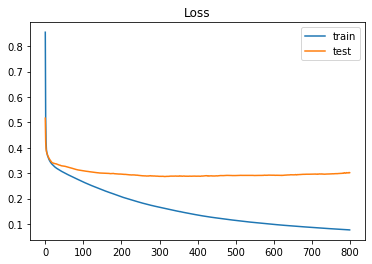

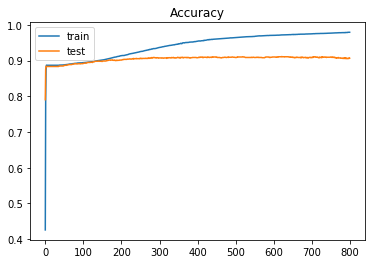

In [14]:
print()
accr = model.evaluate(X_test,Y_test)
# baseline_acc = np.unique(np.argmax(Y, axis=1), return_counts=True)[1].max() / Y.shape[0]
baseline_acc = np.mean(np.mean(Y, axis=0) )
print('\nTest set\n  Accuracy: {:0.3f}\n  Loss: {:0.3f}\n  Baseline:{:0.3f}'.format(accr[1],accr[0], baseline_acc))
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

In [15]:
# Save the model
model.save('../models/predict_affects_1Dec19.h5')

# Recreate the exact same model purely from the file
# model = load_model('../models/predict_affects_18Nov19.h5')

## Evaluation

In [208]:
results = []

threshold = 0.5
Y_test_pred = (model.predict(X_test) > threshold).astype(int)

# MICRO
acc_test = (Y_test_pred == Y_test).mean()
prec, recall, _, _ = precision_recall_fscore_support(Y_test,Y_test_pred, average='micro')
f1 = f1_score(Y_test, Y_test_pred, average='micro')
results.append({'Eval Metric': 'MICRO', 'Accuracy': acc_test, 'Precision': prec, 
                          'Recall': recall, 'F1 Score': f1})

# BINARY
acc_test = (Y_test_pred == Y_test).mean()
prec, recall, _, _ = precision_recall_fscore_support(Y_test.ravel(),Y_test_pred.ravel(), average='binary')
f1 = f1_score(Y_test.ravel(), Y_test_pred.ravel(), average='binary')
results.append({'Eval Metric': 'BINARY', 'Accuracy': acc_test, 'Precision': prec, 
                'Recall': recall, 'F1 Score': f1})

# SAMPLES
acc_test = (Y_test_pred == Y_test).mean()
prec, recall, _, _ = precision_recall_fscore_support(Y_test,Y_test_pred, average='samples')
f1 = f1_score(Y_test, Y_test_pred, average='samples')
results.append({'Eval Metric': 'SAMPLES', 'Accuracy': acc_test, 'Precision': prec, 
                'Recall': recall, 'F1 Score': f1})

# SAMPLES CONFUSION MATRIX
accs, precs, recs, f1s = [], [], [], []
for r in range(Y_test.shape[0]):
    tn, fp, fn, tp = confusion_matrix(Y_test[r,:], Y_test_pred[r,:]).ravel()   
    acc  = (Y_test_pred[r,:] == Y_test[r,:]).mean()
    prec = float(tp / (tp + fp)) if tp + fp != 0.0 else 0.0
    rec  = float(tp / (tp + fn)) if tp + fn != 0.0 else 0.0
    f1 = float(2.0 * ((prec*rec) / (prec + rec))) if prec + rec != 0 else 0  
    accs.append(acc)
    precs.append(prec)
    recs.append(rec)
    f1s.append(f1)
results.append({'Eval Metric': 'SAMPLES CONFUSION MATRIX', 
                'Accuracy': np.mean(accs), 'Precision': np.mean(precs), 
                'Recall': np.mean(recs), 'F1 Score': np.mean(f1s)})

# SAMPLES AVG BINARY
accs, precs, recs, f1s = [], [], [], []
for r in range(Y_test.shape[0]):
    acc = (Y_test_pred[r,:] == Y_test[r,:]).mean()
    prec, recall, _, _ = precision_recall_fscore_support(Y_test[r,:],Y_test_pred[r,:], average='binary')
    f1 = f1_score(Y_test[r,:], Y_test_pred[r,:], average='binary')
    accs.append(acc)
    precs.append(prec)
    recs.append(recall)
    f1s.append(f1)
binary_precs = precs
results.append({'Eval Metric': 'SAMPLES AVG BINARY', 
                'Accuracy': np.mean(accs), 'Precision': np.mean(precs), 
                'Recall': np.mean(recs), 'F1 Score': np.mean(f1s)})

# SAMPLES AVG MICRO
accs, precs, recs, f1s = [], [], [], []
for r in range(Y_test.shape[0]):
    acc = (Y_test_pred[r,:] == Y_test[r,:]).mean()
    prec, recall, _, _ = precision_recall_fscore_support(np.expand_dims(Y_test[r,:], 0),
                                                         np.expand_dims(Y_test_pred[r,:], 0), average='micro')
    f1 = f1_score(np.expand_dims(Y_test[r,:], 0), np.expand_dims(Y_test_pred[r,:], 0), average='micro')
    accs.append(acc)
    precs.append(prec)
    recs.append(recall)
    f1s.append(f1)
micro_precs = precs
results.append({'Eval Metric': 'SAMPLES AVG MICRO', 
                'Accuracy': np.mean(accs), 'Precision': np.mean(precs), 
                'Recall': np.mean(recs), 'F1 Score': np.mean(f1s)})

results = pd.DataFrame(results, columns = ["Eval Metric", "Accuracy", "Precision", "Recall", "F1 Score"])
results.set_index("Eval Metric")

C:\Users\morod\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\morod\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)
C:\Users\morod\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\morod\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy  Precision    Recall  F1 Score
Eval Metric                                                      
MICRO                     0.906915   0.761194  0.291429  0.421488
BINARY                    0.906915   0.761194  0.291429  0.421488
SAMPLES                   0.906915   0.321011  0.235942  0.257031
SAMPLES CONFUSION MATRIX  0.906915   0.321011  0.235942  0.257031
SAMPLES AVG BINARY        0.906915   0.321011  0.235942  0.257031
SAMPLES AVG MICRO         0.906915   0.321011  0.235942  0.257031

### Confusion Matrix

Positive  Negative
Positive  0.033910  0.010638
Negative  0.082447  0.873005

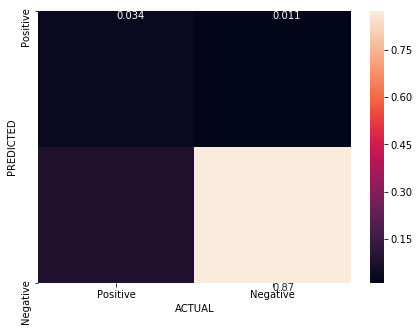

In [106]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(Y_test.ravel(), Y_test_pred.ravel()).ravel()

#normalize
cm = np.array([[tp, fp], [fn, tn]])
cm = cm / cm.sum()

df_cm = pd.DataFrame(cm, index = [i for i in ['Positive', 'Negative']],
                  columns = [i for i in ["Positive", 'Negative']])
plt.figure(figsize = (7,5))
sn.heatmap(df_cm, annot=True, annot_kws={"ha": 'left',"va": 'top'})
plt.xlabel("ACTUAL")
plt.ylabel("PREDICTED")
df_cm

### Correlation with sentiment analysis

In [107]:
labels = list(data.loc[:, 'interest':'desire'].columns)
pos_val = ['hope', 'joy', 'gratitude', 'interest', 'understanding', 'relief', 'surprise', 'desire']
neg_val = ['fear', 'sorrow', 'anger', 'alarm', 'confusion', 'frustration', 'boredom', 'disgust']
pos_val_ind = [labels.index(i) for i in pos_val]
neg_val_ind = [labels.index(i) for i in neg_val]

In [108]:
from sklearn.preprocessing import MinMaxScaler

# sentiment analysis from our model and data
Y_pred = model.predict(X)
Y_sent_pred = Y_pred.copy()
Y_sent = Y.copy()

for c in neg_val_ind:
    Y_sent_pred[:, c] = Y_sent_pred[:, c] * -1
    Y_sent[:, c] = Y_sent[:, c] * -1
    
Y_sent_pred = Y_sent_pred.sum(axis=1)
Y_sent_pred = Y_sent_pred / Y_sent_pred.max()
# scaler = MinMaxScaler(feature_range=(-1, 1))
# Y_sent_pred = scaler.fit_transform(Y_sent_pred.astype(np.float)) # normalize

Y_sent = Y_sent.sum(axis=1)
Y_sent = Y_sent / Y_sent.max()
# scaler = MinMaxScaler(feature_range=(-1, 1))
# Y_sent = scaler.fit_transform(Y_sent.astype(np.float)) # normalize


# sentiment analysis from textblob
Y_sent_blob = data.loc[:, 'desc'].apply(lambda x: TextBlob(x).sentiment.polarity).values

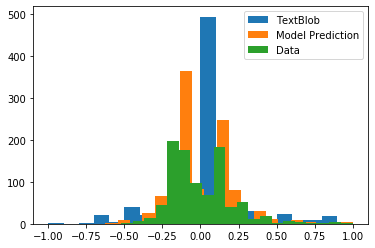

In [109]:
plt.hist(Y_sent_blob, bins=20)
plt.hist(Y_sent, bins=20)
plt.hist(Y_sent_pred, bins=20)
plt.legend(["TextBlob", "Model Prediction", "Data"])

The R2 value between the DATA and BLOB is  -0.5135749034184072
The R2 value between the DATA and MODL is  0.8402443469790273
The R2 value between the BLOB and MODL is  0.11637871951583845


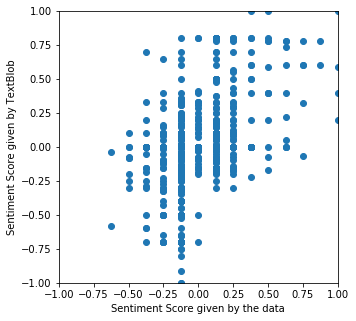

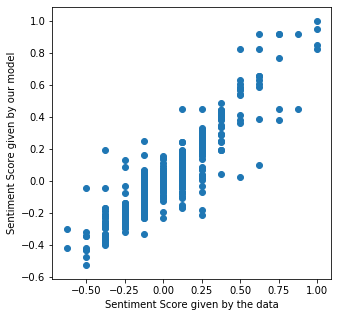

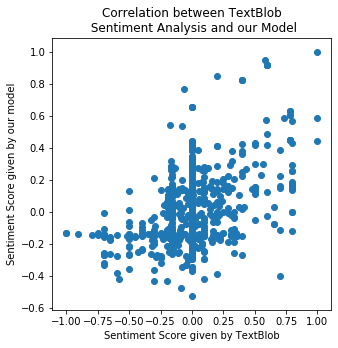

In [111]:
print("The R2 value between the DATA and BLOB is ", r2_score(Y_sent, Y_sent_blob))
print("The R2 value between the DATA and MODL is ", r2_score(Y_sent, Y_sent_pred))
print("The R2 value between the BLOB and MODL is ", r2_score(Y_sent_blob, Y_sent_pred))

plt.rcParams['figure.figsize'] = (5,5)
plt.ylim([-1,1])
plt.xlim([-1,1])
plt.scatter(Y_sent, Y_sent_blob)
plt.xlabel("Sentiment Score given by the data")
plt.ylabel("Sentiment Score given by TextBlob")
plt.show()
plt.scatter(Y_sent, Y_sent_pred)
plt.xlabel("Sentiment Score given by the data")
plt.ylabel("Sentiment Score given by our model")
plt.show()
plt.scatter(Y_sent_blob, Y_sent_pred)
plt.xlabel("Sentiment Score given by TextBlob")
plt.ylabel("Sentiment Score given by our model")
plt.title("Correlation between TextBlob\n Sentiment Analysis and our Model")
plt.show()

## Try out the trained model

In [225]:
def predict_affect(new_desc, print_result=False, latex_format=False):
    new_embed = np.expand_dims(get_embedding(clean_text(new_desc)), axis=0)
    # IF CONCAT
    # new_embed = new_embed.reshape(new_embed.shape[:-2] + (-1,))
    # padded = np.zeros((1, 887))
    # padded[:new_embed.shape[0],:new_embed.shape[1]] = new_embed
    # new_embed = padded

    # IF SUM
    new_embed = np.sum(new_embed, axis=1)

    pred = model.predict(new_embed)
    labels = data.loc[:, 'interest':'desire'].columns
    
    if not print_result:
        return dict(sorted(zip(labels, pred[0]), key=lambda x: x[1], reverse=True))
    
    if not latex_format:
        print(new_desc, "->", labels[np.argmax(pred)])
        for l, p in sorted(zip(labels, pred[0]), key=lambda x: x[1], reverse=True)[:3]:
            print("\t{:10}   {:0.3f}".format(l[:10], p))
        print()
    else:
        print("{} & {} \\\\".format(new_desc, labels[np.argmax(pred)]))
#         print("{} & {} ({:0.1f}) & {} ({:0.2f}) \\\\".format(new_desc, top[0][0], top[0][1],
#                                                           top[1][0], top[1][1]))
            
        
        
predict_affect("the robot looks down", print_result=True, latex_format=True)
predict_affect("the robot looks up", print_result=True,latex_format=True)
predict_affect("the robot moves away", print_result=True,latex_format=True)
predict_affect("the robot moves closer", print_result=True,latex_format=True)
predict_affect("the robot shakes his head", print_result=True,latex_format=True)
predict_affect("the robot nods his head", print_result=True,latex_format=True)
predict_affect("the robot squeals", print_result=True,latex_format=True)
predict_affect("the robot dances side to side", print_result=True,latex_format=True)
predict_affect("the robot is happy", print_result=True,latex_format=True)
predict_affect("squinting eyes", print_result=True,latex_format=True)

the robot looks down & fear \\
the robot looks up & interest \\
the robot moves away & sorrow \\
the robot moves closer & interest \\
the robot shakes his head & frustration \\
the robot nods his head & interest \\
the robot squeals & joy \\
the robot dances side to side & interest \\
the robot is happy & joy \\
squinting eyes & sorrow \\


## Analysis of Affects of Individual Words

In [218]:
word_counter = Counter()
for p in data.desc:
    word_counter.update(p.split())

print("Vocabulary size: ", len(word_counter.keys()))

vocab = list(word_counter.keys())

Vocabulary size:  877


In [229]:
word_affects = []
for word in tqdm(vocab):
    curr_word = predict_affect(word)
    curr_word['word'] = word
    word_affects.append(curr_word)
word_affects = pd.DataFrame(word_affects).set_index("word")

100%|██████████| 877/877 [01:02<00:00, 14.11it/s]


In [251]:
word_affects[:5]

relief      hope    desire  understanding     alarm  interest  \
word                                                                      
the     0.693287  0.525112  0.318267       0.300134  0.141411  0.060834   
robot   0.046807  0.069755  0.048523       0.029899  0.315837  0.071957   
comes   0.499147  0.494679  0.121966       0.341361  0.016259  0.315098   
closer  0.089548  0.085277  0.042551       0.140588  0.135587  0.758514   
to      0.365033  0.580936  0.305660       0.598223  0.191994  0.654465   

        confusion   disgust  gratitude   boredom      fear  surprise  \
word                                                                   
the      0.055679  0.055500   0.051730  0.041606  0.034995  0.031686   
robot    0.005838  0.051897   0.044538  0.034643  0.095528  0.022631   
comes    0.010907  0.003593   0.020523  0.024328  0.052547  0.130397   
closer   0.004170  0.013501   0.047149  0.036502  0.092220  0.019094   
to       0.023696  0.032562   0.024897  0.220798  0.004238  0.078011   

        frustration       joy    sorrow     anger  
word                                               
the        0.028935  0.024906  0.017598  0.007047  
robot      0.011218  0.005623  0.130278  0.011866  
comes      0.010193  0.113915  0.023611  0.003600  
closer     0.004686  0.028606  0.001123  0.001960  
to         0.003569  0.098576  0.013251  0.019687

### Top words of every affect

In [292]:
for a in word_affects.columns:
    print("Top words for {}".format(a.upper()))
    affect_col = word_affects.sort_values(by=[a], ascending=False)[a][:3]
    for w, p in zip(affect_col.index, affect_col.tolist()):
        print("  {}: {:0.3f}".format(w, p))
    print()

Top words for RELIEF
  help: 0.977
  enjoy: 0.977
  go: 0.972

Top words for HOPE
  nice: 0.990
  enjoy: 0.990
  give: 0.989

Top words for DESIRE
  go: 0.702
  nice: 0.657
  enjoy: 0.649

Top words for UNDERSTANDING
  nice: 0.986
  enjoy: 0.969
  wise: 0.946

Top words for ALARM
  good: 0.923
  best: 0.840
  close: 0.837

Top words for INTEREST
  nice: 0.995
  enjoy: 0.990
  ever: 0.986

Top words for CONFUSION
  good: 0.923
  jumbled: 0.911
  backwords: 0.885

Top words for DISGUST
  good: 0.873
  unsaid: 0.764
  closed: 0.721

Top words for GRATITUDE
  thanks: 0.390
  just: 0.369
  hand: 0.364

Top words for BOREDOM
  nothing: 0.377
  sleeping: 0.359
  boredom: 0.352

Top words for FEAR
  good: 0.981
  unsaid: 0.872
  fight: 0.844

Top words for SURPRISE
  nice: 0.985
  smart: 0.948
  wise: 0.873

Top words for FRUSTRATION
  technoloy: 0.438
  fidget: 0.174
  theyve: 0.143

Top words for JOY
  nice: 0.992
  shucking: 0.969
  giggling: 0.965

Top words for SORROW
  sorrowfully: 0.934

### Top words for valence pairs

In [301]:
valence_pairs = [tuple(i.split("-")) for i in ['alarm-interest', 'confusion-understanding', 'frustration-relief', 'sorrow-joy',
                 'anger-gratitude','fear-hope','boredom-surprise','disgust-desire']]

word_valences = pd.DataFrame()
for v1, v2 in valence_pairs:
    v = '{}-{}'.format(v1, v2)
    word_valences[v] = word_affects[v1]+word_affects[v2]
    col = word_valences.sort_values(by=[v], ascending=False)[v][:3]
    print("Top words for {}".format(v))
    for w, p in zip(col.index, col.tolist()):
        print("  {}: {:0.3f}".format(w, p))
    print()


Top words for alarm-interest
  enjoy: 1.645
  nice: 1.630
  wise: 1.559

Top words for confusion-understanding
  up: 1.395
  wise: 1.039
  nice: 1.006

Top words for frustration-relief
  nice: 1.001
  enjoy: 0.991
  help: 0.985

Top words for sorrow-joy
  nice: 1.002
  shucking: 0.982
  laughing: 0.970

Top words for anger-gratitude
  angerit: 0.700
  angry: 0.649
  hand: 0.402

Top words for fear-hope
  good: 1.873
  fight: 1.666
  desired: 1.444

Top words for boredom-surprise
  nice: 0.999
  smart: 0.958
  wise: 0.878

Top words for disgust-desire
  good: 0.908
  closed: 0.860
  unsaid: 0.805



## Affect of most common words

In [324]:
most_common = Counter([item for sublist in [d.split() for d in data['desc'].values] for item in sublist]).most_common(100)
most_common = [i[0] for i in most_common if i[0].lower() not in STOPWORDS]

for w in most_common[:40]:
    print("Top affects for {}".format(w.upper()))
    for affect, prob in list((predict_affect(w).items()))[:3]:
        print(" {}: {:0.3f}".format(affect, prob))
    print()

Top affects for ROBOT
 alarm: 0.316
 sorrow: 0.130
 fear: 0.096

Top affects for ARMS
 joy: 0.204
 understanding: 0.084
 hope: 0.075

Top affects for HEAD
 hope: 0.251
 understanding: 0.215
 alarm: 0.198

Top affects for LOOKS
 hope: 0.362
 understanding: 0.311
 interest: 0.111

Top affects for EYES
 confusion: 0.467
 alarm: 0.290
 surprise: 0.086

Top affects for MOVES
 interest: 0.557
 fear: 0.403
 surprise: 0.182

Top affects for MOVED
 relief: 0.477
 hope: 0.458
 desire: 0.315

Top affects for BACK
 relief: 0.449
 understanding: 0.407
 hope: 0.341

Top affects for LIKE
 relief: 0.498
 understanding: 0.482
 hope: 0.229

Top affects for MOVE
 hope: 0.823
 interest: 0.784
 relief: 0.655

Top affects for MOVING
 hope: 0.679
 relief: 0.671
 interest: 0.369

Top affects for EYE
 alarm: 0.313
 sorrow: 0.153
 relief: 0.121

Top affects for AROUND
 relief: 0.545
 hope: 0.497
 alarm: 0.193

Top affects for LIFTS
 relief: 0.231
 fear: 0.125
 desire: 0.063

Top affects for LITTLE
 hope: 0.877


## Ablation study

In [129]:
ABLATION_STUDY = []

def train_and_eval(NAME):
    
    # Get the embeddings
    data[NAME+'_bert'] = data[NAME].apply(get_embedding)
    X = np.stack(data[NAME+'_bert'].values, axis=0)
    X = np.sum(X, axis=1)
    Y = data.loc[:, 'interest':'desire'].values
        
    # Split data
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
    
    # Train model
    model = Sequential()
    model.add(Dense(128, activation='sigmoid'))
    model.add(Dense(16, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    epochs = 800
    history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=epochs, verbose=0, batch_size=846)
    model.summary()

    # Plot history
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()
    plt.show();

    # Evaluate
    threshold = 0.5
    Y_test_pred = (model.predict(X_test) > threshold).astype(int)
    acc_test = (Y_test_pred == Y_test).mean()
    prec, recall, _, _ = precision_recall_fscore_support(Y_test,Y_test_pred, average='micro')
    f1 = f1_score(Y_test, Y_test_pred, average='micro')
    
    # Collect results
    myresults = {'Name': NAME, 'Eval Metric': 'MICRO', 
                 'Accuracy': acc_test, 'Precision': prec, 'Recall': recall, 'F1 Score': f1}
    ABLATION_STUDY.append(myresults)
    return myresults
    


### No stop words

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_16 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


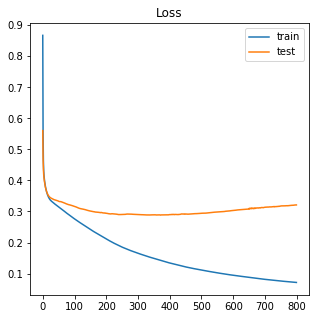

{'Name': 'desc_nostp',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.898936170212766,
 'Precision': 0.6385542168674698,
 'Recall': 0.3028571428571429,
 'F1 Score': 0.4108527131782945}

In [130]:
NAME = 'desc_nostp'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if word not in STOPWORDS))
train_and_eval(NAME)

### Only stop words (should not work well)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_18 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


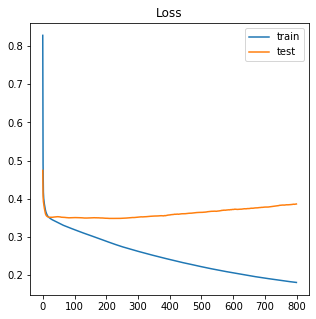

{'Name': 'desc_onlystop',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8783244680851063,
 'Precision': 0.38235294117647056,
 'Recall': 0.07428571428571429,
 'F1 Score': 0.12440191387559808}

In [131]:
NAME = 'desc_onlystop'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if word in STOPWORDS))
train_and_eval(NAME)

### No nouns

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_20 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


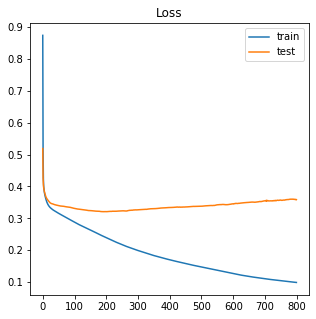

{'Name': 'desc_nonouns',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8882978723404256,
 'Precision': 0.5614035087719298,
 'Recall': 0.18285714285714286,
 'F1 Score': 0.27586206896551724}

In [132]:
NAME = 'desc_nonouns'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                not dict(TextBlob(d).tags)[word].startswith("NN")))
train_and_eval(NAME)

### Only nouns

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_22 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


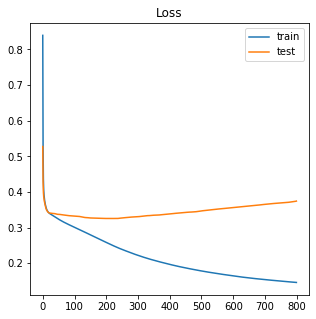

{'Name': 'desc_onlynouns',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8756648936170213,
 'Precision': 0.4117647058823529,
 'Recall': 0.16,
 'F1 Score': 0.23045267489711935}

In [133]:
NAME = 'desc_onlynouns'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                   dict(TextBlob(d).tags)[word].startswith("NN")))
train_and_eval(NAME)

### No verbs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_23 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_24 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


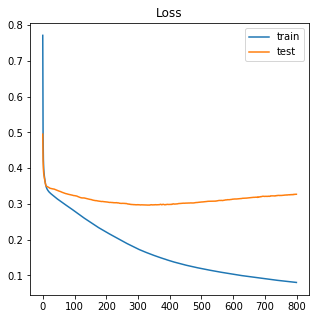

{'Name': 'desc_noverbs',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8949468085106383,
 'Precision': 0.6440677966101694,
 'Recall': 0.21714285714285714,
 'F1 Score': 0.32478632478632474}

In [134]:
NAME = 'desc_noverbs'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        not dict(TextBlob(d).tags)[word].startswith("VB")))
train_and_eval(NAME)

### Only verbs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_26 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


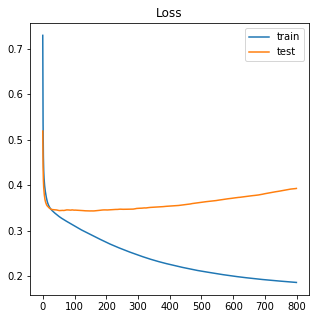

{'Name': 'desc_onlyverbs',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.875,
 'Precision': 0.3142857142857143,
 'Recall': 0.06285714285714286,
 'F1 Score': 0.10476190476190476}

In [135]:
NAME = 'desc_onlyverbs'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        dict(TextBlob(d).tags)[word].startswith("VB")))
train_and_eval(NAME)

### No adjectives

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_28 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


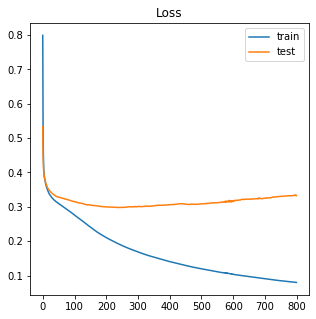

{'Name': 'desc_noadj',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.901595744680851,
 'Precision': 0.684931506849315,
 'Recall': 0.2857142857142857,
 'F1 Score': 0.4032258064516129}

In [136]:
NAME = 'desc_noadj'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        not dict(TextBlob(d).tags)[word].startswith("JJ")))
train_and_eval(NAME)

### Only adjectives

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_30 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


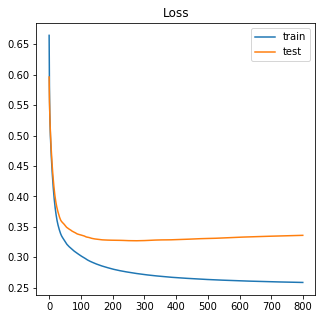

{'Name': 'desc_onlyadj',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8922872340425532,
 'Precision': 0.6756756756756757,
 'Recall': 0.14285714285714285,
 'F1 Score': 0.2358490566037736}

In [137]:
NAME = 'desc_onlyadj'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        dict(TextBlob(d).tags)[word].startswith("JJ")))
train_and_eval(NAME)

### No adverbs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_31 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_32 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


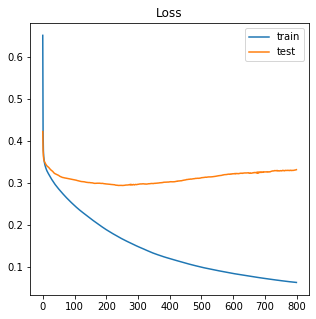

{'Name': 'desc_noadv',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.9029255319148937,
 'Precision': 0.6883116883116883,
 'Recall': 0.3028571428571429,
 'F1 Score': 0.4206349206349207}

In [138]:
NAME = 'desc_noadv'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        not dict(TextBlob(d).tags)[word].startswith("RB")))
train_and_eval(NAME)

### Only adverbs

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_34 (Dense)             (None, 16)                2064      
Total params: 395,408
Trainable params: 395,408
Non-trainable params: 0
_________________________________________________________________


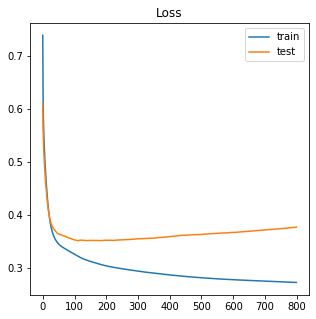

{'Name': 'desc_onlyadv',
 'Eval Metric': 'MICRO',
 'Accuracy': 0.8789893617021277,
 'Precision': 0.18181818181818182,
 'Recall': 0.011428571428571429,
 'F1 Score': 0.02150537634408602}

In [139]:
NAME = 'desc_onlyadv'
data[NAME] = data['desc'].apply(lambda d: ' '.join(word for word in d.split() if \
                                                        dict(TextBlob(d).tags)[word].startswith("RB")))
train_and_eval(NAME)

## ABLATION STUDY RESULTS

In [190]:
# ADD IN THE BASE RESULTS
ABLATION_STUDY.insert(0, {'Name': 'base', 'Eval Metric': 'MICRO', 
                 'Accuracy': 0.904, 'Precision': 0.696, 'Recall': 0.314, 'F1 Score': 0.433})

In [206]:
pd.DataFrame(ABLATION_STUDY)

Name Eval Metric  Accuracy  Precision    Recall  F1 Score
0             base       MICRO  0.904000   0.696000  0.314000  0.433000
1       desc_nostp       MICRO  0.898936   0.638554  0.302857  0.410853
2    desc_onlystop       MICRO  0.878324   0.382353  0.074286  0.124402
3     desc_nonouns       MICRO  0.888298   0.561404  0.182857  0.275862
4   desc_onlynouns       MICRO  0.875665   0.411765  0.160000  0.230453
5     desc_noverbs       MICRO  0.894947   0.644068  0.217143  0.324786
6   desc_onlyverbs       MICRO  0.875000   0.314286  0.062857  0.104762
7       desc_noadj       MICRO  0.901596   0.684932  0.285714  0.403226
8     desc_onlyadj       MICRO  0.892287   0.675676  0.142857  0.235849
9       desc_noadv       MICRO  0.902926   0.688312  0.302857  0.420635
10    desc_onlyadv       MICRO  0.878989   0.181818  0.011429  0.021505

In [205]:
fancy_names = {"base": "Base",
              "desc_nostp": "No Stop Words",
              "desc_onlystop": "Only Stop Words",
              "desc_nonouns": "Removed Nouns",
              "desc_onlynouns": "Only Nouns",
              "desc_noverbs": "Removed Verbs",
              "desc_onlyverbs": "Only Verbs",
              "desc_noadj": "Removed Adjectives",
              "desc_onlyadj": "Only Adjectives",
              "desc_noadv": "Removed Adverbs",
              "desc_onlyadv": "Only Adverbs",}

ab_df = pd.DataFrame(ABLATION_STUDY)
maxes = list(dict(ab_df.loc[:, 'Accuracy':'F1 Score'].idxmax(axis = 0)).values())
for i, exp in enumerate(ABLATION_STUDY):
    print("\\textbf{{{}}} & {:0.1f}\% & {:0.1f}\% & {:0.1f}\% & {:0.1f}\% \\\\"\
          .format(fancy_names[exp['Name']], exp['Accuracy']*100, exp['Precision']*100, exp['Recall']*100, exp['F1 Score']*100))

\textbf{Base} & 90.4\% & 69.6\% & 31.4\% & 43.3\% \\
\textbf{No Stop Words} & 89.9\% & 63.9\% & 30.3\% & 41.1\% \\
\textbf{Only Stop Words} & 87.8\% & 38.2\% & 7.4\% & 12.4\% \\
\textbf{Removed Nouns} & 88.8\% & 56.1\% & 18.3\% & 27.6\% \\
\textbf{Only Nouns} & 87.6\% & 41.2\% & 16.0\% & 23.0\% \\
\textbf{Removed Verbs} & 89.5\% & 64.4\% & 21.7\% & 32.5\% \\
\textbf{Only Verbs} & 87.5\% & 31.4\% & 6.3\% & 10.5\% \\
\textbf{Removed Adjectives} & 90.2\% & 68.5\% & 28.6\% & 40.3\% \\
\textbf{Only Adjectives} & 89.2\% & 67.6\% & 14.3\% & 23.6\% \\
\textbf{Removed Adverbs} & 90.3\% & 68.8\% & 30.3\% & 42.1\% \\
\textbf{Only Adverbs} & 87.9\% & 18.2\% & 1.1\% & 2.2\% \\


In [207]:
data[:50]

file_name   embed_code  \
20                anim_play_requestplay_level2_01.avi  nMbYAONAots   
21                              anim_play_idle_02.avi  DDU9jeo3Y8c   
22  anim_reacttoface_unidentified_03_head_angle_40...  D0MyBZXzlFg   
23  anim_reacttoface_unidentified_03_head_angle_-2...  Z2uHBYREfkA   
24                    anim_reacttocliff_wheely_02.avi  0Zc1B5s1_6Q   
25            anim_reacttocliff_turtlerollfail_03.avi  WUAXLO7FZW0   
26            anim_reacttocliff_turtlerollfail_01.avi  E5xh2nBIcn8   
27                anim_reacttocliff_turtleroll_05.avi  -i_o_BBMOAY   
28                anim_reacttocliff_turtleroll_03.avi  vPAddajZ_Xc   
29                anim_reacttocliff_turtleroll_01.avi  dHXdJoDUDGs   
30            anim_reacttocliff_stuckrightside_02.avi  tCiz0acrjR8   
31             anim_reacttocliff_stuckleftside_03.avi  EhKA_jkc41o   
32             anim_reacttocliff_stuckleftside_01.avi  kPkh13DUWws   
33                    anim_reacttocliff_pickup_05.avi  cJ4BbiTnTnk   
34                    anim_reacttocliff_pickup_03.avi  Eff6KSGC3LI   
35                    anim_reacttocliff_pickup_01.avi  nGGheI60fPM   
36       anim_reacttocliff_faceplantroll_armup_02.avi  P-V0dLJ_x_c   
37             anim_reacttocliff_faceplantroll_02.avi  WaiXS00fUZ4   
38                anim_reacttocliff_edgeliftup_01.avi  4ZVNzp91eKU   
39              anim_reacttoblock_triestoreach_01.avi  0osCZJKEA1A   
40     anim_reacttoblock_success_01_head_angle_40.avi  CThKF71At9w   
41    anim_reacttoblock_success_01_head_angle_-20.avi  ty5rs_bEaHE   
42              anim_reacttoblock_stuckonblock_01.avi  lmuVLmto_Ew   
43  anim_reacttoblock_react_short_02_head_angle_40...  QwLrSQHRScE   
44  anim_reacttoblock_react_short_02_head_angle_-2...  lFjCyCifrzY   
45  anim_reacttoblock_react_short_01_head_angle_20...  mOmxiGR326U   
46                     anim_reacttoblock_react_01.avi  I_DQfrAoH6U   
47       anim_reacttoblock_react_01_head_angle_20.avi  1SGipbQPnpc   
48                   anim_reacttoblock_react_01_0.avi  7mKmQieLUxQ   
49                anim_reacttoblock_placeblock_01.avi  Tvb2NwCTCjQ   
50        anim_reacttoblock_lifteffortplacelow_01.avi  nDKTvYj5J1E   
51          anim_reacttoblock_lifteffortpickup_01.avi  Kimrr1vaRNk   
52           anim_reacttoblock_happydetermined_01.avi  6hNff_TFo_g   
53           anim_reacttoblock_frustrated_int1_01.avi  OHZYeOCiVCI   
54               anim_reacttoblock_focusedeyes_01.avi  kyWHFtkPzQc   
55         anim_reacttoblock_ask_01_head_angle_40.avi  QHB5FCQUqBs   
56        anim_reacttoblock_ask_01_head_angle_-20.avi  cLmO_YBTw44   
57           anim_reacttoblock_admirecubetower_01.avi  jdEZeyFv9Pk   
58                   anim_qa_firmwaremessaging_01.avi  car2W3tFdUc   
59         anim_pyramid_thankyou_01_head_angle_20.avi  X2aUb5wCMNc   
60                        anim_pyramid_success_01.avi  Qu1TKbZNH40   
61          anim_pyramid_reacttocube_happy_mid_01.avi  p1KHzvMgJBA   
62         anim_pyramid_reacttocube_happy_high_02.avi  zm-PKUis4Gw   
63     anim_pyramid_reacttocube_frustrated_mid_01.avi  kgTjAgBYuho   
64    anim_pyramid_reacttocube_frustrated_high_01.avi  PSEWzsZ4qik   
65  anim_pyramid_lookinplaceforfaces_short_head_an...  k5bY7fcIl4s   
66        anim_pyramid_lookinplaceforfaces_medium.avi  bDwiQc9GrNY   
67  anim_pyramid_lookinplaceforfaces_medium_head_a...  ZT3AAmWHo3o   
68  anim_pyramid_lookinplaceforfaces_long_head_ang...  VfijM3b8Mgo   
69  anim_pyramid_lookinplaceforfaces_long_head_ang...  OjVut6DO8pM   

    video_title                                        description  interest  \
20           21  The robot comes closer to the camera, showing ...         0   
21           22  The robot stays pretty still and then seems to...         0   
22           23  The robot stares right at the camera and then ...         1   
23           24  The robot hangs its head low and looks as thou...         0   
24           25  The robot turns around to get away and then sl...       